# Traffic Sign Recognition


Progetto del corso di Machine Learning AA 2017/2018

Corso di Laurea Magistrale in Informatica, Università di Bologna

- Ceccolini Enrico (800490)
- Valguarnera Enrico (800115)

### Lavoro svolto in breve
**Scelta dell'argomento:**
Realizzazione di un **classificatore di segnali stradali** (single-image, multi-class classification problem)

**Selezione di paper recenti**: 
- Traffic Sign Recognition with Multi-Scale Convolutional Networks redatto da Pierre Sermanet e Yann LeCun [1]. Tale studio racchiude le tecniche principali avanzate da diversi team di ricercatori (tra cui il loro) durante le competizioni IJCNN, sfide che avevano come obiettivo la realizzazione del miglior classificatore di segnali stradali (single-image, multi-class classification problem) partendo dal dataset GTSRB.
- GTSRB - Man vs. computer: Benchmarking machine learning algorithms for traffic sign recognition [2].
- Fully Convolutional Networks for Semantic Segmentation [3].
    

**Ricerca disponibilità del codice**: Non si è fatto riferimento a nessun progetto esisente. Le architetture sono state realizzate utilizzando la libreria Keras e il linguaggio Python partendo dalla nozioni presenti nel paper di riferimento.

**Ripetizione dell'esperimento**: Per poter effettuare l'esperimento si è aderito completamente alle fasi proposte dal paper di riferimento: aumento del dataset, normalizzazione del dataset e di definizione delle architetture.

**Cambio del goal/data/architetture/tecniche**: Sono state proposte delle modifiche in tutte le fasi: diverse tecniche di aumento e normalizzazione del dataset, aumento profondità delle reti e varie tecniche di training.


# 1) Il Dataset GTSRB

Il dataset GTSRB (German Traffic Sign Benchmark) è mantenuto dall'instituto di Neural Information Processing dell'università tedesca Ulm. Le immagini che lo compongono sono state ottenute seguendo una metodologia sistematica che verrà descritta in seguito. Grazie a questa tecnica il dataset e il relativo team tedesco ha riscosso successo tra i ricercatori.

Per uniformità rispetto al paper, in modo da poter confrontare i risultati ottenuti, è stato scelto di utilizzare la versione del dataset indicata per l'*online competition stage* e non l'ultima presentata dall'istituto che si occupa delle competizioni. Nella fase finale del nostro progetto si utilizzerà invece il nuovo dataset per poter confrontare i nostri risultati con quelli sottomessi dalla comunità di ricercatori. E' infatti sempre possibile sottomettere i propri risultati. Il [dataset]('http://benchmark.ini.rub.de/index.php?section=gtsrb&subsection=dataset#Downloads')  per l'*online competition stage* contiene 39209 immagini, divise tra tra training-set (26,640 immagini) e test-set (12,569 immagini). Ogni immagine contiene un singolo segnale stradale appartenente ad una delle 43 classi presenti. Le dimensioni delle immagini variano da un minimo di 15x15 ad un massimo di 250x250 pixel.

Le immagini contenute nel dataset presentano le caratteristiche riscontrabili nel mondo reale dovute alle condizioni meteo, alla camera posta sul veicolo e alle condizioni fisiche del segnale stradale.

Le difficoltà riscontrate sono:
- diverse inquadrature,
- condizioni di luce (irradiazione, saturazione e basso contrasto),
- sfocature dovute al movimento del veicolo,
- danni fisici,
- graffiti e adesivi,
- bassa risoluzione. 

Per le suddette problematiche il dataset viene considerato rappresentativo per il problema.

#### Load del dataset e visualizzazione del dataset

Di seguito il plot di 43 immagini (una per classe) raffiguranti dei campioni, scelti in modo casuale dal dataset.

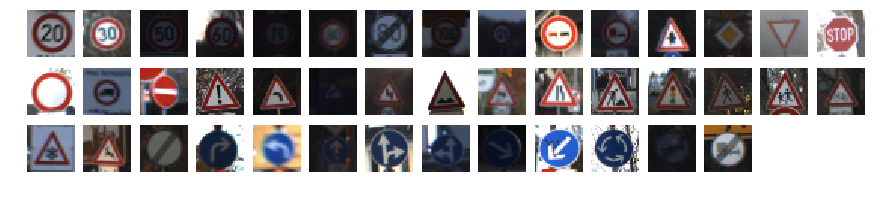

In [15]:
import my_mod_load as load
train, valid, test = load.load_train_valid_test()

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
load.display_sample_images(X_train, y_train)

#### Istogramma rappresentante la distribuzione di campioni per classe

Come è ben visibile dal grafico, la quantità di campioni per classe è molto sbilanciata. Il paper non interviene su questa situazione, magari con tecniche di bilanciamento tramite la creazione di nuovi campioni, ottenendo comunque un'ottima accuratezza sul test-set.

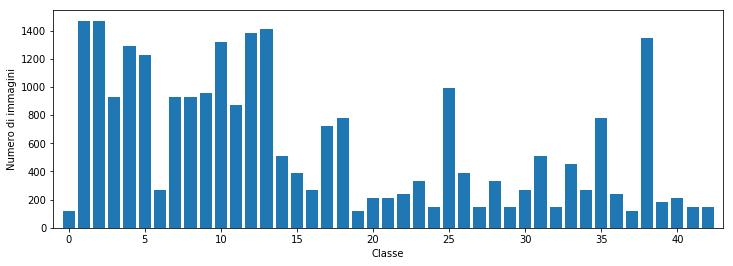

In [2]:
load.display_class_distribution(y_train)

# 2) Pre-elaborazione

## 2.1) Valid-set

Come evdenzia il paper, la selezione delle immagini che popoleranno il validation-set è cruciale in GTSRB. Mischiare le immagini e selezionare un sottoinsieme porterebbe ad avere un validation-set troppo simile al training-set e quindi all'impossibilità di ottenere valori di performance accurati del modello.

Il motivo è da trovare nella tecnica utilizzata per ottenere le immagini del dataset. Le immagini sono state estratte da tracce video. Per ogni traccia il segnale stradale presente è stato catturato circa 30 volte con aumento progressivo della risoluzione a mano a mano che la camera si avvicina al segnale.

Per la definizione del validation set si è estratta in maniera casuale una traccia per ognuna delle 43 classi, in modo da non avere immagini dello stesso identico segnale stradale nei diversi insiemi.

In [3]:
print("Dimensione del training-set: {}".format(len(X_train)))
print("Dimensione del valid-set: {}".format(len(X_valid)))

Dimensione del training-set: 25350
Dimensione del valid-set: 1290


## 2.2) Pre-processing

Prima della fase di allenamento il training-set è stato aumentato e normalizzato con l'obiettivo di indirizzare la ricerca delle caratteristiche fondamentali ed ottenere una base di dati maggiormente rappresentativa.
Il codice sorgente relativo a questa fase è presente nel file *script/preprocessing.py*, e spiegato qui di seguito.

### 2.2.1) Normalization

Per ottenere un modello con performance elevate Pierre Sermanet e Yann LeCun consigliano di:
- ridimensionare le immagini alla dimensione 32x32
- convertire lo spazio di colori da RGB a YUV
- applicare una normalizzazione globale sul canale Y
- apllicare una normalizzazione locale sul canale Y
- lasciare inalterati i canali U e V

Al termine del paper si legge che usare i canali colore non aumenta in modo considerevole l'accuratezza del modello generato. Verificheremo questa affermazione effettuando dei test su dati non aumentati per poi decidere se procedere in grayscale o meno. L'impatto sulla dimensione del dataset è notevole e risulterebbe utile non considerare i colori per effettuare i training, considerato che la nostra scheda video che possiede solamente 2 GB di memoria. Il Dataset in grayscale occupa 100MB contro i 327MB a colori. In ottica di quintuplicare i dati del training-set potremmo non avere abbastanza memoria disponibile.

Di seguito la funzione da noi utilizzata per la manipolazione di una singola immagine (le immagini sono state ridimensionate durante il caricamento del dataset). In questa versione si escludono i colori.

``` Python
def normalize_img(img):
    # converte l'immagine in YUV mantenedo esclusivamente il canale Y (luminanza)
    img_y = cv2.cvtColor(img, (cv2.COLOR_BGR2YUV))[:,:,0]    
    # Normalizzazione globale
    # distribuisce la luminosità nell'istogramma incrementando il contrasto globale
    img_y = cv2.equalizeHist(img_y)     
    # rappresenta i valori in un range da 0 a 1
    img_y = (img_y / 255.).astype(np.float32)     
    # Equalizzazione locale
    # esegue la Contrast Limited Adaptive Histogram Equalization
    # l'obbiettivo è quello di enfatizzare gli angoli dei segnali stradali
    img_y = (exposure.equalize_adapthist(img_y) - 0.5)     
    img_y = img_y.reshape(img_y.shape + (1,))

    return img_y
```

La **exposure.equalize_adapthist()** consiste nella Contrast Limited Adaptive Histogram Equalization (CLAHE), ottima per far risaltare i dettagli anche in aree dell'immagine molto scure o molto chiare in modo da migliorare l'estrazione delle features. Questa operazione di equalizzazione locale risulta essere dispendiosa e quindi non particolarmente adatta in ottica real time. 

E' pensabile utilizzare una equalizzazione più leggera a discapito di alcuni punti in accuratezza ad esempio sostituendola con una **exposure.adjust_log()**.

#### Visualizzazione di un'immagine originale a confronto con una normalizzata


Using TensorFlow backend.


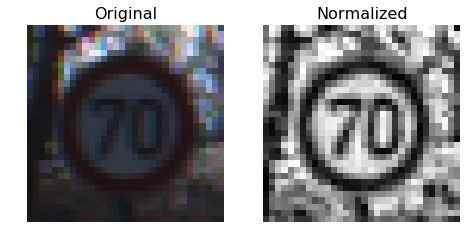

In [4]:
import plot_functions as pltfun
pltfun.original_vs_normalized(X_train[5000])

### 2.2.2) Jittering
---
Per ottenere un modello con performance elevate Pierre Sermanet e Yann LeCun consigliano di aumentare i campioni del training-set andando a generare immagini a partire da quelle già presenti.
Le trasformazioni da applicare devono generare segnali stradali plausibili, cioè che differiscano dagli originali per inquadratura della camera posta sull'eventuale veicolo.

Il paper consiglia di perturbare le immagini originali in modo casuale sulle seguenti proprietà, con i relativi range:
- posizione ([-2, 2] pixels)
- scala ([.9, 1.1] ratio)
- rotazione ([-15, 15] gradi)

Per l'aumento dei dati è stata utilizzata la libreria Keras. In particolare tramite il modulo ImageDataGeneration. Nel ciclo for sottostante è riportata la generazione di un nuovo insieme di immagini delle stesse dimensioni del training set originario.


```Python
datagen = ImageDataGenerator(
        # perturbed in position ([-2, 2] pixels)
        width_shift_range=0.07, # for images 32x32
        height_shift_range=0.07,    
        # perturbed in scale ([.9, 1.1] ratio)
        # si è deciso di applicare uno zoom
        zoom_range=0.15,
        # perturbed in rotation ([-15, 15] degrees)
        rotation_range=15,
        fill_mode='nearest')

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=len(X_train)):
    X_train_aug = X_batch.astype('uint8')
    y_train_aug = y_batch
    break

```

### 2.2.3 Blurring
---
Lo studio \[2\] (Man vs. computer: Benchmarking machine learning algorithms for traffic sign recognition) mostra le difficoltà dell'approccio algoritmico rispetto a quello umano nella classificazione di segnali stradali ripresi da una camera in movimento quando questa si trova molto vicina (le performance umane risultano migliorare con l'aumento delle dimensioni dell'immagine). Poiché il problema sembra essere il forte effetto di motion blur che crea lo sdoppiamento dell'immagine (espressa come "ghost image"), si è deciso di aumentare i campioni del training-set aggiungendo un insieme di immagini corrispondente all'insieme originale al quale è stato applicato un blur. Guardando le immagini in cui è presente la "ghost image" si nota come l'effetto è per lo più orizzontale dunque si è cercato di simularlo in questa direzione.

E' stato utilizzato un kernel che calcola il valore medio e lo trasferisce in una particolare direzione. E' possibile verificare la tecnica [qui](https://www.packtpub.com/mapt/book/application_development/9781785283932/2/ch02lvl1sec21/motion-blur).

#### motion blur kernel utilizzato = 
\begin{bmatrix}
 0 & 0 & 0 \\
 1/3 & 1/3 & 1/3 \\
 0 & 0 & 0 \\
\end{bmatrix}

```Python
def motion_blur(img):
    size = 3
    # generating the kernel
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size
    img_bl = cv2.filter2D(img, -1, kernel_motion_blur)

    return img_bl
```

#### Visualizzazione di un'immagine originale a confronto con una sfocata e successivamente normalizzata.

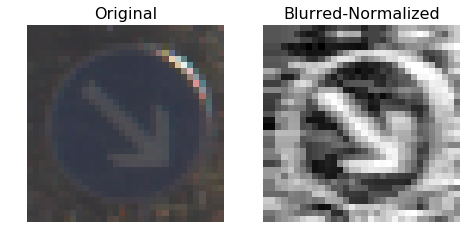

In [5]:
pltfun.orginal_vs_blurred(X_train[23456])

#### Load del dataset manipolato

E' stato applicato il jittering cinque volte e il blurring una volta, ottenendo un fattore moltiplicativo x6.

Dimensione del training-set: 152100


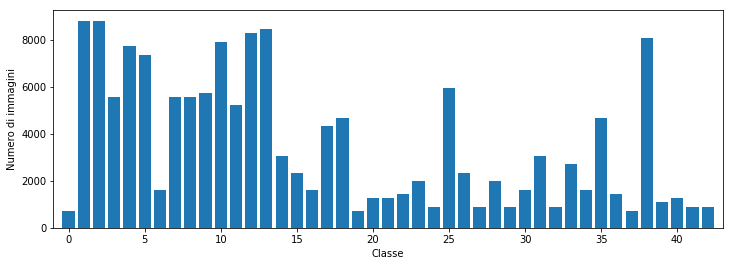

In [6]:
dirname = '2018-02-06_1645_online_augm_blur'

X_train_m, y_train_m = load.load_manipulated_train(dirname)
X_valid_m, y_valid_m = load.load_normalized_valid(dirname)
X_test_m, y_test_m = load.load_normalized_test(dirname)
print("Dimensione del training-set: {}".format(len(X_train_m)))

load.display_class_distribution(y_train_m)

## 3) Architecture

Il paper presenta diverse architetture. La principale (quella risultata più prestante) non corrisponde ad una classica rete convoluzionale dove i vari livelli si susseguono in maniera puramente sequenziale ma, come si può notare dalla figura sotto, sono presenti dei collegamenti che saltano dei livelli in modo da dare in pasto al classificatore features derivate da diversi stadi (con stadio si intende la sequenza: convoluzione, attivazione, pooling). Questo permette al classificatore di utilizzare caratteristiche globali (forme e strutture) e locali (dettagli precisi).


Reti con questa architettura vengono definite ConvNet MS (Multi-Scale).

E' di nostro interesse replicare sia l'architettura MS che l'architettura Single-Scale per poter confrontare le performance.

<img src="images/Figure_net.jpg" alt="Rappresentazione visuale della rete" style="width: 700px;"/>

Si è voluta modificare la profondità della rete raddoppiando il numero di livelli convolutivi. Ad ogni livello convolutivo delle architetture presentate dal paper è stato fatto susseguire un nuovo livello convolutivo. Per non modificare il downsampling eseguito dalle reti (passaggio da 32x32 a 5x5). Per questo è stato modificato il kernel size delle convoluzioni da 5x5 a 3x3.

#### La nostra implementazione della ConvNet MS

```Python
from keras.layers import Dense, Dropout, Flatten, merge
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model

net_name = "sol178ML"
features = [108, 108]
dense_hidden_units = [100]
dropouts = [0.2, 0.2, 0.5]

# input image
inputs = Input(shape=(32, 32, 1))

# Stage 1
# --------
# Prima convloluzione: 3x3 kernel, 1x1 stride, valid padding, outputs 30x30x108
first_layer = Convolution2D(nb_filter=features[0], nb_row=3, nb_col=3, activation='relu')(inputs)
# Seconda convloluzione: 3x3 kernel, 1x1 stride, valid padding, outputs 28x28x108
first_layer = Convolution2D(nb_filter=features[0], nb_row=3, nb_col=3, activation='relu')(first_layer)
# Max pooling: 2x2 stride, outputs 14x14x108
first_p_layer = MaxPooling2D(pool_size=(2, 2))(first_layer)
# Dropout: 0.2
drop_1 = Dropout(dropouts[0])(first_p_layer)

# Stage 2
# ----------
# Branch 1: 
# Max pooling: 2x2 stride, outputs 7x7x108
second_p_layer = MaxPooling2D(pool_size=(2, 2))(drop_1)
first_input_layer = Flatten()(second_p_layer)
# Branch 2: 
# Terza convloluzione: 3x3 kernel, 1x1 stride, valid padding, outputs 12x12x108
second_layer = Convolution2D(nb_filter=features[1], nb_ro=3, nb_col=3, activation='relu')(drop_1)
# Quarta convloluzione: 3x3 kernel, 1x1 stride, valid padding, outputs 10x10x108
second_layer = Convolution2D(nb_filter=features[1], nb_ro=3, nb_col=3, activation='relu')(second_layer)
# Max pooling: 2x2 stride, outputs 5x5x108
third_p_layer = MaxPooling2D(pool_size=(2, 2))(second_layer)
# Dropout: 0.2
drop_2 = Dropout(dropouts[1])(third_p_layer)
second_input_layer = Flatten()(drop_2)

# Classifier
# ---------
# Merge the two branches
input_layer = merge([first_input_layer, second_input_layer], mode='concat', concat_axis=1)
# Fully connected layer: 100 neurons
hidden_layer = Dense(dense_hidden_units[0], activation='sigmoid')(input_layer)
# Dropout: 0.5
drop = Dropout(dropouts[2])(hidden_layer)
# Softmax: 43 neurons
predictions = Dense(43, activation='softmax')(drop)
model = Model(input=inputs, output=predictions)
```

Per completare l'architettura si è selezionata la funzione obiettivo, la tecnica di ottimizzazione e la metrica di valutazione.
Le scelte in questa fase si sono basate sullo studio \[7\](CNN with 3 Spatial Transformers), in cui vengono confrontati diverse tecniche di accelerazione dell'apprendimento tra cui: SGD without momentum(SGD), SGD with Nesterov accelerated gradient (SGD-N), Root Mean Square Propagation (RMSprop) e Adaptive Moment Estimation (Adam).
Il paper ha studiato il comportamento dei vari loss function optimizer al variare dell'archiettura di una rete convoluzionale. Una delle configurazioni risulta particolarmente simile alla nostra poiché provvista esclusivamente di blocchi convoluzionali. 

- Funzione obiettivo: Keras Loss function categorical_crossentropy
- Tecnica di ottimizzazione: Nesterov's Accelerated Gradient Descent

```Python
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

# Stochastic gradient descent optimizer
sgd = SGD(lr=1e-3, decay=1e-4, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
                metrics=['accuracy'],
                loss='categorical_crossentropy')
history_callback = model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid)
```

## 4) Experiments

Sono state implementate le architetture che sono risultate più performanti. In particolare considereremo le soluzioni: \#178 (con le varie configurazioni), \#26 e \#27.

Per verificare che il colore non rappresenta una caratteristica fondamentale sono state effettuate delle prove utilizzando la soluzione \#178 (la più performante secondo il paper), senza effettuare l'aumento del training-set (No jitter).

| Model id | Description (40 ep, 0.01 lr, 0.2-0.2-0.5 dropout)                              | No jitter (test-set acc.) 
| :------: | :--------------------------------------- | --------------------- | :----------------: | :-----------------------: | :-----------------: |
| 178_1  | 2LConvNet **MS** 108-108 + 100-feats CF classifier + **No color** | 96.96%                 |
|  178_1   | 2LConvNet **MS** 108-108 + 100-feats CF classifier + **Color** | 97.39%                 |

E' stato riscontrato un incremento di accuratezza considerando i canali colore, quindi risulta di nostro interesse effettuare esperimenti che mantengano questa informazione. Per le ragioni riportate al punto 2.2.1 non siamo in grado di effettuare esperimenti che vedano il mantenimento del colore su tutte le reti prese in considerazione. Si è scelto di confrontare le varie reti utilizzando il dataset grayscale e, una volta individuata la rete più performante, utilizzaremo un servizio di training online per poter effettuare esperimenti in parallelo con e senza colore.

Le varie soluzioni sono state testate effettuando l'allenamento sul training-set non aumentato, aumentato (senza blur) e aumentato con blur. Tutti gli esperimenti considerano l'utilizzo del validation-set. Si è scelto di utilizzare inizialmente 40 epoche ed un learning rate di 0.01 e dropout dopo ogni livello.

I risultati sono presenti in tabella.


| Model id | Description (40 ep, 0.01 lr, 0.2-0.2-0.5 dropout)                              | No jitter (test-set acc.) | Jitter (test-set acc.) | Jitter + blur (test-set acc.) | Risultato paper (jitter only) |
| :------: | :--------------------------------------- | --------------------- | :----------------: | :-----------------------: | :-----------------: |
|   1     | LeNet-5 | 91.50%                 |       94.40%        |           95.70%           |        x        |
| 178_1  | 2LConvNet **MS** 108-108 + 100-feats CF classifier + No color | 96.96%                 |       99.02%        |           99.30%           |        99.17%        |
|  178_2   | 2LConvNet **MS** 108-200 + 100-feats CF classifier + No color | 96.84%                 |       99.03%        |           99.22%           |          98.85%          |
|  178_3   | 2LConvNet **MS** 108-108 + 100-feats CF classifier + No color | x                     |         x          |           99.23%           |          x          |
|    26    | 2LConvNet **MS** 38-64 + 100-feats CF classifier + No color | x                     |         x          |           98.87%           |          98.59%          |
|    27    | 26 **SS**                                | 97.00%                 |       99.08%        |           99.23%           |          98.20%          |
|   178_1ss | 2LConvNet **SS** 108-108 + 100-feats CF classifier + No color                               | 96.82%                 |       98.96%        |           99.41%           |            x          |



Dalla tabella si nota come l'aumento di dati del training-set presenti un forte impatto sulle performance. Nessun esperimento senza la data augmentation supera la human-performance (calcolata a 98.81%). Aggiungendo i dati ottenuti tramite le tecniche di data augmentation presentata nella sezione 2.2.2 si ottiente una conferma dei risultati presentati nel paper. introducendo nuovi dati con la tecnica presentata nella sezione 2.2.3 (blurring) si ottiene in ogni caso un impatto positivo sulle performance. La scelta di rappresentare le sfocature dovute alla ripresa in movimento viene considerata vincente.

Selezionata la soluzione che si è rivelata più performante, si sono effettuati esperimenti considerando i canali colore o variando gli iperparametri. Le tempistiche di allenamento per questa architettura risultano proibitive su sistemi non dotati di una scheda video dedicata al deep learning, per questo motivo si è utilizzato il servizio FloydHub.

| Model id | Description (40 ep, 0.01 lr, 0.2-0.2-0.5 dropout)                              | No jitter (test-set acc.) | Jitter (test-set acc.) | Jitter + blur (test-set acc.) | Risultato paper (jitter only) |
| :------: | :--------------------------------------- | --------------------- | :----------------: | :-----------------------: | :-----------------: |
| 178_1  | 2LConvNet **MS** 108-108 + 100-feats CF classifier + **No color** | 96.96%                 |       99.02%        |           99.30%           |        99.17%        |
| 178_1  | 2LConvNet **MS** 108-108 + 100-feats CF classifier + **Color** | 97.39%                 |       99.04%       |           99.12%           |        x        |


Dall'esperimento risulta che considerare i colori migliora i risultati su training-set senza dati aumentati mentre risulta non utile e negativo sul training-set con dati aumentati, confermando l'incremento di prestazioni descritto nelle conclusioni del paper.

Si è pensato di diminuire il learning rate e di aumentare il numero di epoche per ottenere in egual modo la convergenza. Impostando il learning rate a 0.001 il processo di apprendimento è risultato troppo lento, non 
ottenendo la convergenza entro le 80 epoche stabilite.
Si è allora aumentato a 0.005 e in 60 epoche si è ottenuto il risultato di 99.33%. 

| Model id | Description (60 ep, 0.005 lr, 0.2-0.2-0.5 dropout)| Jitter + blur (test acc.) | Risultato paper (jitter only) |
| :------: | :--------------------------------------- | --------------------- | :-----------------: |
| 178_1  | 2LConvNet **MS** 108-108 + 100-feats CF classifier + No color | 99.33%                  |        99.17%        |

Da qui in poi verrà utilizzato il dataset GTSRB aggiornato e le architetture che hanno riscontrato le performance migliori dalle prove precendenti. 
Il dataset GTSRB aggiornato consiste in 39,209 immagini per il training (le immagini del dataset GTSRB online più il testset online) e 12,630 nuove immagini per il testset. Il validation-set è stato ottenuto con lo stesso metodo utilizzato al punto 2.1. 

Il risultato di seguito è il migliore prodotto. 

| Model id | Description (40 ep, 0.01 lr, 0.2-0.2-0.5 dropout)| Jitter + blur (test acc.) | Risultato paper (jitter only) |
| :------: | :--------------------------------------- | --------------------- | :-----------------: |
| 178_1  | 2LConvNet **MS** 108-108 + 100-feats CF classifier + No color | 99.11%                  |        98.31% 
| 178_1  | 2LConvNet **SS** 108-108 + 100-feats CF classifier + No color | 98.84%                  |  x

Qui la MS ha superato le prestazioni della SS ottenendo una accuratezza sul test-set del 99.11% contro i 98.31% del modello presentato dagli autori del paper. Con il tentativo di migliorare le prestazioni sono stati eseguiti altri esperimenti che hanno visto l'aumento di epoche da 40 a 60 e la diminuzione del learning rate, tuttavia l'architettura presente nell'ultima tabella è risultato il migliore.

In [7]:
#import plot_functions as pltfun
#pltfun.learning_curve(file_name="2018-02-19_1746_sol178MS_60_0.01_128_0.3_online.log")

---
### Errori di riconoscimento nella fase di testing

Di seguito si visualizzano tutte le stampe delle immagini che non sono state correttamente classificate durante la fase di testing.


In [8]:
import plot_functions as pltfun
import my_mod_load as load
import my_mod_manipulate_image as manipulate
test = load.load_official_testset()
#test = load.load_online_testset()
X_test, y_test = test['features'], test['labels']
X_test_m = list()
for img in X_test:
    X_test_m.append(manipulate.normalize_img(img)) 

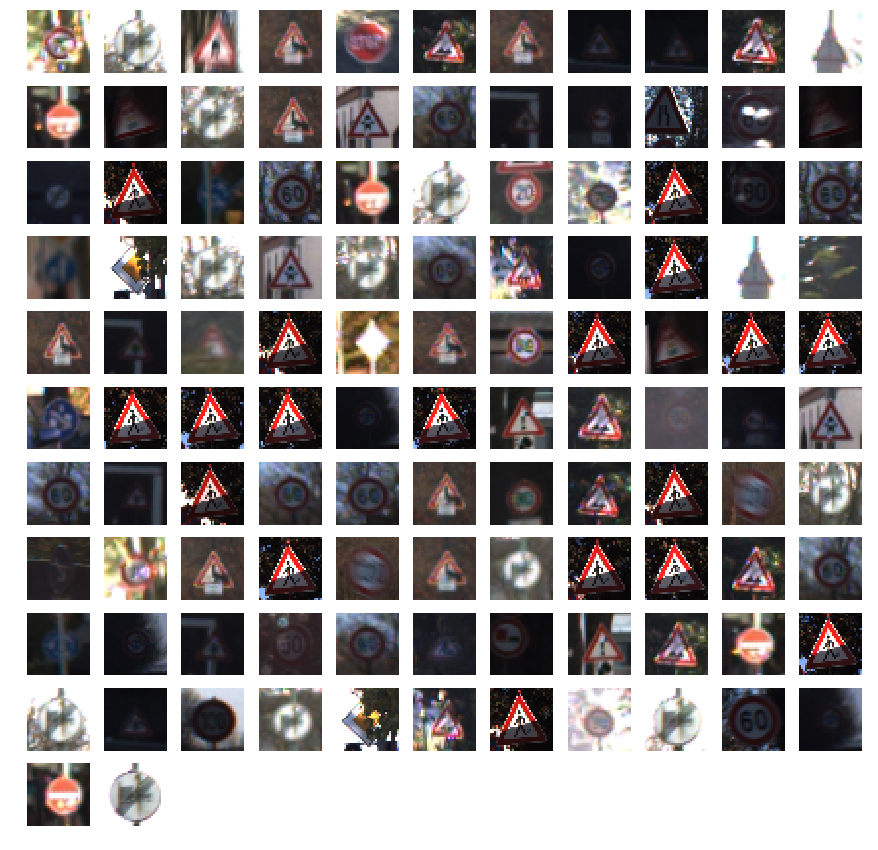

In [9]:
import numpy as np
#model = './final_models/keras/sol178_108-108MS/jitter-blur/model_108-108-100_ep40'
#model = './final_models/keras/sol178_108-108MS/jitter-blur/model_108-108-100_ep60'
#model = '/scripts/models/2018-02-23_1203/model_108-108-100_ep40'
model = './final_models/keras/best/2018-02-20_2227/model_108-108-100_ep40'
X_test_m = np.array(X_test_m)
X_bad_aimed = pltfun.bad_test_aimed(model, X_test_m, y_test, X_test)

In [10]:
print("Sono state classificate erroneamente: {} immagini su {}".format(len(X_bad_aimed), len(X_test)))

Sono state classificate erroneamente: 112 immagini su 12630


Le immagini classificiate erroneamente sono per la maggior parte difficili da riconoscere da un umano. Toltiendo gli errori di cattura del segnale (in alcune immagini non è presente il segnale stradale) le immagini rimanenti hanno una bassissima risoluzione, causa principale degli errori di classificazione. Si notano poi segnali coperti per metà da altri oggetti e segnali dove è comprensibile esclusivamente la forma a causa della forte radiazione solare o di sfocature troppo accentuate. Queste difficoltà rendono difficile il riconoscimento del valore numerico presente nei limiti di velocità, rendendo impossibile distinguere ad esempio se il segnale rappresenta il valore 30 o 60 o 80.

Si deduce che alcune immagini sono facenti parte della stessa traccia. In modo particolare una immagine "pedestrian" che viene classificata erroneamente 18 volte. Sono presenti anche altre tracce ma con un numero limitato di istanze.

In [11]:
# print(X_bad_aimed)

## 5) Test sulle nuove immagini


Per il test su nuove immagini sono stati selezionati dei segnali stradali per lo più situati nella città di Bologna. Le immagini sono state recuperate tramite Google Street View, cercando di costituire un insieme rappresentativo per le caretteristiche di lontananza, inquadratura, luminosità, deterioramento e graffiti. 

Loaded model from disk

Testing: 
well-aimed: 22/24
well-aimed: 0.9167


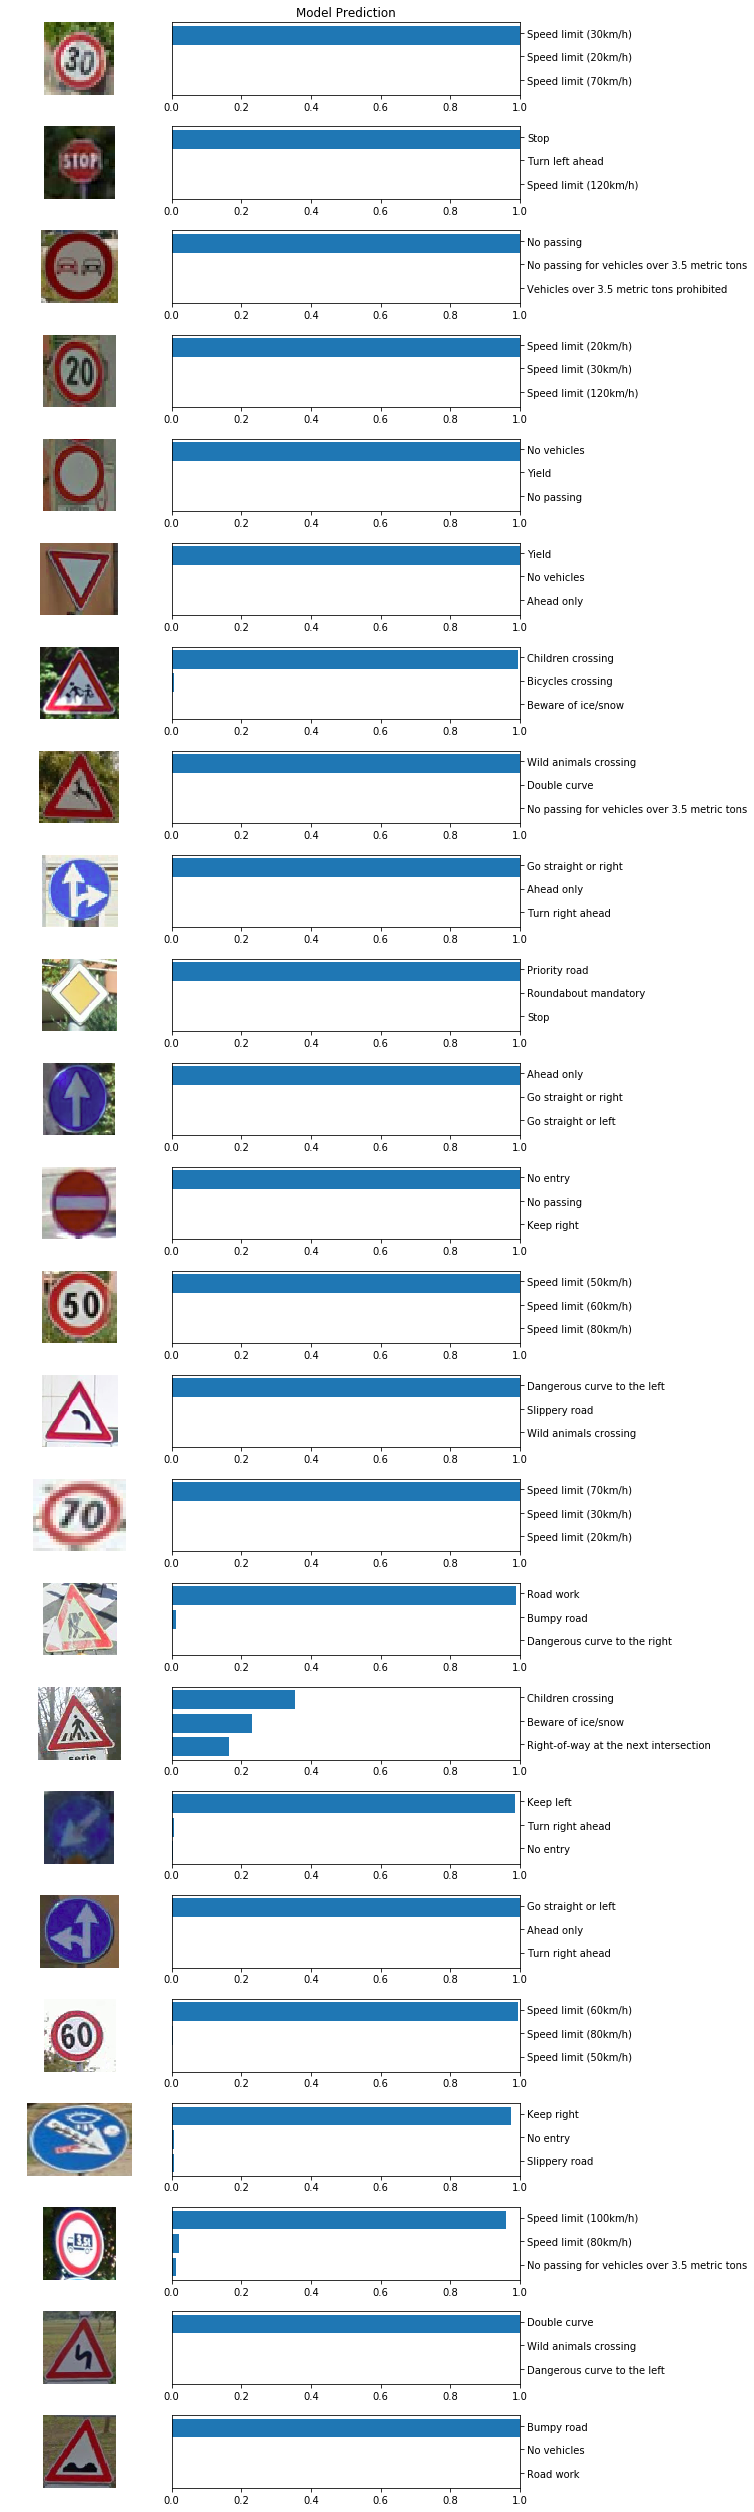

In [12]:
import plot_functions as pltfun
#model = './final_models/keras/sol178_108-108MS/jitter-blur/model_108-108-100_ep40'
model = './final_models/keras/best/2018-02-20_2227/model_108-108-100_ep40'
pltfun.final_image(model)

Il modello si comporta in modo ottimale. Dal test si nota come le immagini correttamente predette vengano collegate alla propria classe con probabilità prossima al 100%. Le immagini classificate erroneamente presentano delle particolarità presenti nella segnaletica italiana, ma non presenti in quella tedesca di GTSRB. Ad esempio nel segnale di "attraversamento pedonale" italiano sono presenti le strisce rappresentatnti la segnaletica orizzontale. Purtroppo queste leggere variazioni sono ricorrenti e il modello non è in grado di affrontarle.

Sono stati infine effettuati dei test sul dataset **DITS - Data set of Italian Traffic Signs**, dataset italiano che ha la particolarità di contenere immagini catturate in condizioni di nebbia e buio. Selezionando le classi in comune con il nostro dataset (22 classi), abbiamo dato in pasto al nostro modello il DITS test-set. La scarsità di classi in comune evidenzia la difficoltà di definire un dataset completo.

In [19]:
import plot_functions as pltfun
import my_mod_load as load
import my_mod_manipulate_image as manipulate
test = load.load_DIST_testset()
#test = load.load_online_testset()
X_test, y_test = test['features'], test['labels']
X_test_m = list()
for img in X_test:
    X_test_m.append(manipulate.normalize_img(img)) 
print(len(X_test))

549


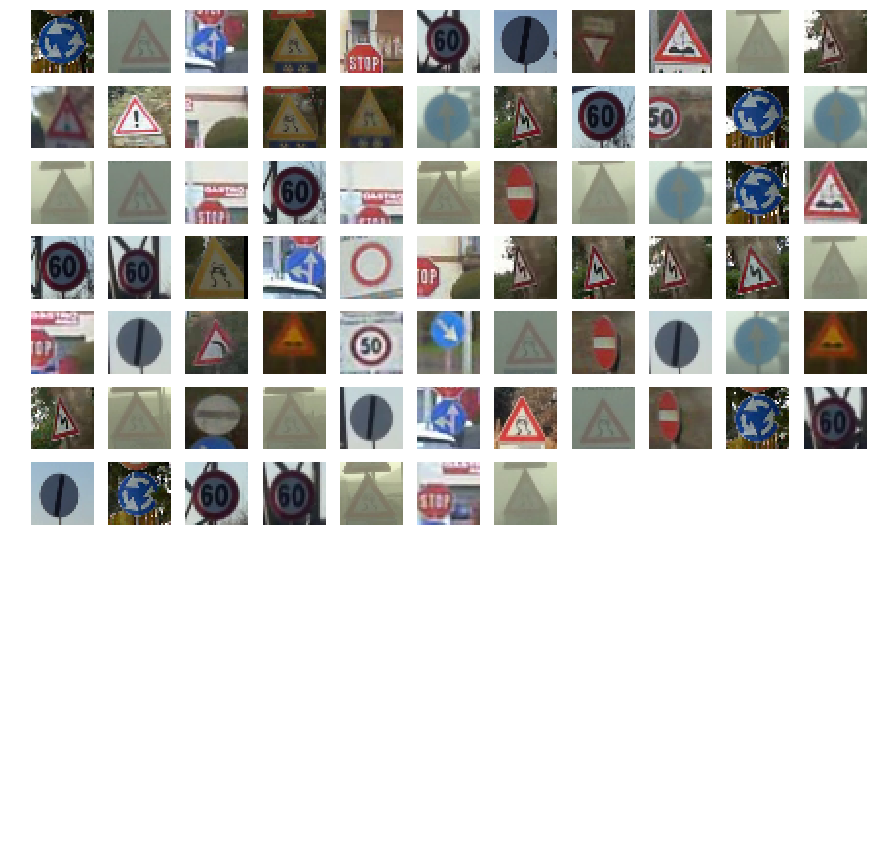

In [21]:
import numpy as np
model = './final_models/keras/best/2018-02-20_2227/model_108-108-100_ep40'
X_test_m = np.array(X_test_m)
X_bad_aimed = pltfun.bad_test_aimed(model, X_test_m, y_test, X_test)
#print(len(X_bad_aimed))

Si è ottenuta una accuratezza del 86.70%. Anche qui vi sono molte immagini riconducibili ad una stessa traccia classificate erroneamente. Non considerando gli errori di cattura del segnale (immagini dove non è presente il segnale o in piccolissima parte), si nota una difficoltà nel distinguere tra il limite dei 60km/h e quello degli 80km/h e la risposta alla presenza di nebbia non è totalmente positiva. Si vede inoltre come il modello non sia stato allenato per riconoscere segnali stradali che presentano una forte inclinazione del cartello o inquadrature laterali dello stesso.

## 6) FCN - Fully Convolutional Networks

Il nostro approccio, come tutti quelli sottomessi nella pagina del dataset GTSRB, non è capace di elaborare immagini di dimensione arbitraria. L'input viene ridimensionato ad una dimensione fissa per poi passarlo alla rete. Questo metodo su immagini larghe può causare perdita di informazione e su immagini piccole può introdurre elementi artificiosi dannosi al classificatore. Questa tecnica non è necessaria agli umani che sono in grado di riconoscere immagini di tutte le dimensioni. Le CNN, che sono ispirate ai processi biologici effettuati dalla corteccia visiva animale, possono superare questa limitazione tramite l'utilizzo esclusivo di livelli convolutivi, andando ad escludere i livelli densi. 

Per condurre esperimenti si è convertito il modello ottenuto dalla fase precedente in uno fully convolutional seguendo quanto presentato nel paper  \[3\] (Fully Convolutional Networks for Semantic Segmentation).

![Rappresentazione visuale della rete FCN](images/FCN.png)

Siccome le convoluzioni vengono eseguite con padding "valid", le dimensioni diminuiscono di 2 ad ogni convoluzione. Si ha così che H1 = H-4 e che H2 = (H1/2)-4. Ciò che avviene ad W è del tutto analogo.

Es. H, W = 32.

32x32x1 ---> 30x30x108 ---> 28x28x108 ---> 14x14x108 ---> 12x12x108 ---> 10x10x108 ---> 5x5x108 ---> 1x1x100 ---> 1x1x43

Convertire i livelli fully connected in livelli convoluzionali permette alla rete di fornire in output un tensore composto da 43 (numero delle classi) heatmap. \[6\] prevede l'utilizzo di una rete deconvoluzionale in grado di eseguire un operazione di upsampling utile per l'operazione di semantic segmentation. Le nostre prove si limitano all'utilizzo delle heatmap per comprendere se forniscono informazioni sufficienti a poter effettuare una detection del segnale stradale all'interno dell'immagine e a poter comprendere di quale classe esso fa parte.
Una heatmap corrisponde alla mappa delle attivazioni per una data classe su un'immagine in input. La heatmap della classe del segnale stradale presente in un'immagine, può essere pensata come la rappresentazione a bassa risoluzione dell'immagine di partenza dove, in corrispondenza dell'oggetto riconosciuto sono presenti alte probabilità per quella classe. Da questa idea si analizzeranno diversi output per verificare la fedeltà e il grado di approssimazione.

### 6.1 Conduzione del test

Il test ha come scopo la definizione dell'accuratezza nella classificazione e nell'individuazione (detection) di segnali stradali utilizzando la nostra rete FCN. In particolare si cercherà di comprendere la percentuale dell'area che il segnale deve occupare nella immagine elaborata dalla rete per ottenere risultati apprezzabili.
Per condurre questo test si sono utilizzate immagini prese dal dataset di test GTSDB, contenente riprese dell'intera carreggiata catturate da una camera posta di fronte al veicolo.

Da ogni immagine intera, ne sono state estrapolate altre 5, aventi differenti percentuali di ricoprimento. La prima immagine avente percentuale 100% è stata ottenuta ritagliando il cartello dall'immagine intera, mantenendolo in posizione centrale e in modo da far occupare la quasi totalità dell'immagine. Successivamente sono state calcolate le risoluzioni delle altre immagini da ritagliare (sempre dall'immagine intera originale) con una percentuale di copertura inferiore. Le percentuali calcolate sono 50%, 25%, 15%, 10%. 

Le immagini in cui il cartello copre il 100% dell'area, simulano le immagini presenti nel dataset utilizzato per l'allenamento della rete. Per questo motivo verranno caricate con risoluzione 32x32 e l'output di conseguenza avrà dimensione 1x1x43. Ci si aspetta che la classe corrispondente presenti la probabilità più alta.
Rispettivamente per le altre percentuali di copertura, le risoluzioni di caricamento delle immagini sono di 64x64, 128x128, 156x156, 184x184. In questo modo verranno considerate immagini con risoluzione fino a cinque volte maggiore rispetto a quelle per su cui la rete è stata allenata.
Queste immagini tornano in output rispettivamente tensori di dimensione 9x9x43, 25x25x43, 32x32x43, 39x39x43.

### Studio delle heatmap

Di seguito le immagini ottenute con il procedimento descritto in precedenza e la relativa rappresentazione grafica delle heatmap. Non sono state inserite le immagini con percentuale di copertura 100%, risultate sempre corrette al fine della classificazione e senza interesse per quanto riguarda la detection. I colori più accessi presenti nelle heatmap corrispondono ad attivazioni di alta probabilità fino ad arrivare al colore viola corrispondente alla non attivazione.

<img src="images/test_fcn/final/30/unified.png" alt="drawing" style="width: 700px;"/>

<img src="images/test_fcn/final/no_entry/unified.png" alt="drawing" style="width: 700px;"/>

<!-- <img src="images/test_fcn/final/keep_right/unified.png" alt="drawing" style="width: 700px;"/> -->

<img src="images/test_fcn/final/yield/unified.png" alt="drawing" style="width: 700px;"/>

Per il problema della classificazione si è pensato di cercare tra le 43 heatmap risultanti quella che presenta la  maggior quantità di attivazioni attraverso la somma delle probabilità. Non risulta vero, tranne per l'analisi dell'immagine "100%" e pochi altri casi, che in questo modo si ottiene la classe del segnale presente nell'immagine.
Questo è dovuto alla presenza di classi che prevalgono in ogni caso, trovando attivazioni su caratteristiche che hanno in comune con elementi dello sfondo. Si nota in particolare come questi presentano forme squadrate (yield,  priority,...) e dunque pattern riscontrabili ad esempio in pali e case. Si ricorda che la rete è stata allenata su immagini in cui l'elemento da classificare ricopriva l'intera immagine e che dunque non è a "conoscenza" di elementi estranei.Questo interferisce ovviamente anche nel problema di detection, dove pur selezionando la heatmap del segnale presente nell'immagine, le attivazioni si troveranno anche in corrispondenza degli elementi estranei.

Per quanto riguarda la detection sugli altri segnali stradali si ha un'ottima approssimazione sulla posizione del cartello nell'immagine, non si notano attivazioni completamente al di fuori dell'area coperta dal segnale o comunque la concentrazione di attivazioni si trova all'interno dei margini definiti dai cartelli.


## Conclusioni

Le CNN si sono dimostrate uno strumento ideale per la risoluzione del problema di classificazione di segnali stradali. Per tale problema rimangono solo le sfide di definire un dataset ancora più significativo di GTSRB per due ragioni principali:

1. Le 43 classi del dataset GTSRB risultano essere veramente poche a confronto delle 300 differenti categorie identificate dalla convenzione di Vienna sul traffico stradale [7], basti pensare all'assenza di tutte le classi di forma quadrata (es. "strada senza uscita" o "strada riservata ai veicoli a motore", ...).
2. Le piccole variazioni tra cartelli della stessa classe ma in uso in stati differenti rendono complicato il riconoscimento automatico. Il modello da noi ottenuto risente di questa problematica (vedi sez. 5 Test sulle nuove immagini, "Pedestrian" e "No passing for veichles over 3.5 tons"). Tra i possibili sviluppi futuri interessanti vi è sicuramente l'implementazione di tecniche in grado di affrontare questa sensibilità alle piccole variazioni.

L'accuratezza del nostro modello sul testset fornito da GTSRB si posiziona alle spalle di quella ottenuta dallo studio di Álvaro Arcos-García and Juan A. Álvarez-García and Luis M. Soria-Morillo [7], considerato il miglior risultato sottomesso. Tale studio prevede l'utilizzo di combinazioni di Spatial Transformer Networks posizionate in punti diversi della rete neurale principale, con il compito di andare a centrare il segnale stradale all'interno dell'immagine eliminando completamente lo sfondo.

Le prove effettuate riguardanti la conversione della rete in una Fully Convolutional Network mostrano chiaramente le potenzialità di questa tecnologia. A partire da una rete già allenata per un compito differente dalla detection si sono ottenute delle buone approssimazioni sulla posizione ricoperta dal segnale stradale in immagini dove questo occupava una piccola porzione della superfice.
La SegNet[8] è un esempio di rete FCN allenabile per il problema di road scene segmentation. Tra gli elementi nella scena riconosciuti dalle rete vi sono i segnali stradali intesi come entità generica, non distinguendo la classe rappresentata. Tuttavia una volta a conoscenza degli esatti pixel dove il cartello è presente, diventa semplice creare l'input per un classificatore.

## Bibliografia e Link utili

[\[1\] Traffic sign recognition with multi-scale Convolutional Networks]('https://www.researchgate.net/publication/224260345_Traffic_sign_recognition_with_multi-scale_Convolutional_Networks')

[\[2\] GTSRB - Man vs. computer: Benchmarking machine learning algorithms for traffic sign recognition]('http://dx.doi.org/10.1016/j.neunet.2012.02.016')

[\[3\] Fully Convolutional Networks for Semantic Segmentation]('https://arxiv.org/abs/1411.4038')

[\[4\] OpenCV, EqualizeHist]('https://docs.opencv.org/2.4/modules/imgproc/doc/histograms.html?highlight=equalizehist')

[\[5\] scikit-image, exposure.equalize_adapthist]('http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_adapthist')

[\[6\] Histogram equalization]('https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html')

[\[7\] CNN with 3 Spatial Transformers, DeepKnowledge Seville, Álvaro Arcos-García and Juan A. Álvarez-García and Luis M. Soria-Morillo]('https://www.sciencedirect.com/science/article/pii/S0893608018300054?via%3Dihub')

[\[8\] Economic comission for Europe, Inland transport comitee. Convention on road signs and signals, 1968]('http://www.unece.org/fileadmin/DAM/trans/conventn/signalse.pdf')

[\[9\] SegNet]('https://arxiv.org/abs/1511.02680')